In [1]:
# File management

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
!pwd

/content


In [4]:
cd /content/drive/My Drive/PyTorch/data


/content/drive/My Drive/PyTorch/data


In [5]:
!ls

4	 cifar10-cnn.pth  model1.txt  model3.pth  model4.txt
4.zip	 cifar10.tgz	  model2.pth  model3.txt
cifar10  model1.pth	  model2.txt  model4.pth


In [6]:
# code for extracting zip file

# # importing required modules 
# from zipfile import ZipFile 
  
# # specifying the zip file name 
# file_name = "4.zip"
  
# # opening the zip file in READ mode 
# with ZipFile(file_name, 'r') as zip: 
#     # printing all the contents of the zip file 
#     zip.printdir() 
  
#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 
#     print('Done!')

In [7]:
# Exploratory analysis

In [8]:
# import required modules
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import datetime
import matplotlib.pyplot as plt
from torchsummary import summary

In [9]:
# set random seed to get reproducible results
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
# Image processing
transform = transforms.Compose([ #torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                #torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [11]:
# take dataset from folders and split it into train, validation and test sets

# set paths
train_data_dir = '4/train/' # put path of training dataset
val_data_dir = '4/val/' # put path of validation dataset
test_data_dir = '4/test/' # put path of test dataset

# Load Images

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=4)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

print('number of images in train set =',len(trainset))
print('trainset class-indices =',trainset.classes)
print('number of images in validation set =',len(valset))
print('trainset class-indices =',valset.classes)
print('number of images in test set =',len(testset))
print('trainset class-indices =',testset.classes)

number of images in train set = 13200
trainset class-indices = ['Ibizan_hound', 'aircraft_carrier', 'beer_bottle', 'bolete', 'boxer', 'carton', 'dome', 'electric_guitar', 'file', 'french_bulldog', 'garbage_truck', 'golden_retriever', 'gordon_setter', 'hair_slide', 'hourglass', 'house_finch', 'komondor', 'malamute', 'meerkat', 'pencil_box', 'prayer_rug', 'reel', 'rock_beauty', 'scoreboard', 'solar_dish', 'stage', 'street_sign', 'tank', 'tile_roof', 'tobacco_shop', 'trifle', 'white_wolf', 'yawl']
number of images in validation set = 3300
trainset class-indices = ['Ibizan_hound', 'aircraft_carrier', 'beer_bottle', 'bolete', 'boxer', 'carton', 'dome', 'electric_guitar', 'file', 'french_bulldog', 'garbage_truck', 'golden_retriever', 'gordon_setter', 'hair_slide', 'hourglass', 'house_finch', 'komondor', 'malamute', 'meerkat', 'pencil_box', 'prayer_rug', 'reel', 'rock_beauty', 'scoreboard', 'solar_dish', 'stage', 'street_sign', 'tank', 'tile_roof', 'tobacco_shop', 'trifle', 'white_wolf', 'yaw

In [12]:
# Class names
classes = testset.classes
classes

['Ibizan_hound',
 'aircraft_carrier',
 'beer_bottle',
 'bolete',
 'boxer',
 'carton',
 'dome',
 'electric_guitar',
 'file',
 'french_bulldog',
 'garbage_truck',
 'golden_retriever',
 'gordon_setter',
 'hair_slide',
 'hourglass',
 'house_finch',
 'komondor',
 'malamute',
 'meerkat',
 'pencil_box',
 'prayer_rug',
 'reel',
 'rock_beauty',
 'scoreboard',
 'solar_dish',
 'stage',
 'street_sign',
 'tank',
 'tile_roof',
 'tobacco_shop',
 'trifle',
 'white_wolf',
 'yawl']

In [13]:
# visualise a batch

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl: # here in single iteration images contains 128 images and labels contain 128 labels
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0)) # 16 columns
        break # we are breaking out with one iteration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


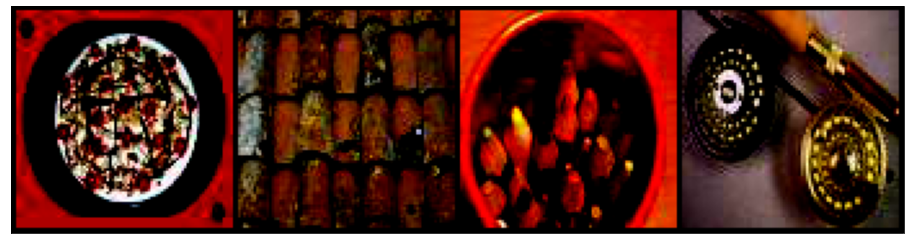

In [14]:
# let's visualise a single trainset batch
show_batch(trainloader)

In [15]:
# Let's define Models now

In [16]:
# Base Model
# Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,f):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        datetime_object = datetime.datetime.now()

        f.write(str(datetime_object)+" - "+"Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f} \n".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'])) 

In [17]:
# Helper class and functions to use GPU
# Code to use GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
# Get the device name
device = get_default_device()
device

device(type='cuda')

In [19]:
# load dataset to GPU
train_loader = DeviceDataLoader(trainloader, device)
val_loader = DeviceDataLoader(valloader, device)
test_loader = DeviceDataLoader(testloader, device)

In [20]:
# we will extend the ImageClassificationBase class to define our model

# Models

In [21]:
class Net1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(  # we create a model named network
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3), 

            nn.Flatten(), 
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 33))
        
    def forward(self, xb):
        return self.network(xb) # we pass a batch into network and return the output

In [22]:
class Net2(ImageClassificationBase):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=33)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
class Net3(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3,3),

        nn.AvgPool2d(kernel_size=(7,7), stride=1),

        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 33)
    )

  def forward(self, xb):
    return self.network(xb)

In [24]:
class Net4(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        

        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(3,3),

        nn.AvgPool2d(kernel_size=(4,4), stride=1),

        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 33)
    )

  def forward(self, xb):
    return self.network(xb)

In [25]:
# Boiler plate functions to fit, train and get test scores.

In [26]:
# boiler plate code to fit the data
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, f,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    for epoch in range(epochs):
        # Training Phase
        train_losses = []
        train_accuracies=[]
        for i, data in enumerate(tqdm(train_loader), 0):
          model.train()
          loss, acc = model.training_step(data)
          train_losses.append(loss)
          train_accuracies.append(acc)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result, f)
        history.append(result)
    return history

In [27]:
# Let us look at how the network performs on the test dataset.
def test(testloader, model, set_name):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('\nAccuracy of the network on the %s images: %d %%' % (set_name, accuracy))
    return accuracy

In [28]:
# class-wise accuracy
def classwise_test(testloader, model):
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data     
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('\nclass-wise accuracy')
    for i in range(n_class):
        print('Accuracy of %10s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [29]:
# Train models

In [30]:
# Model 1

In [31]:
# print model Summary
model1 = Net1()
to_device(model1, 'cuda')
summary(model1, (3,84,84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 84, 84]             896
              ReLU-2           [-1, 32, 84, 84]               0
            Conv2d-3           [-1, 64, 84, 84]          18,496
              ReLU-4           [-1, 64, 84, 84]               0
         MaxPool2d-5           [-1, 64, 42, 42]               0
            Conv2d-6          [-1, 128, 42, 42]          73,856
              ReLU-7          [-1, 128, 42, 42]               0
            Conv2d-8          [-1, 128, 42, 42]         147,584
              ReLU-9          [-1, 128, 42, 42]               0
        MaxPool2d-10          [-1, 128, 21, 21]               0
           Conv2d-11          [-1, 256, 21, 21]         295,168
             ReLU-12          [-1, 256, 21, 21]               0
           Conv2d-13          [-1, 256, 21, 21]         590,080
             ReLU-14          [-1, 256,

In [32]:
# train model
f = open("model1.txt", "w")
num_epochs = 50
history1 = fit(num_epochs, model1, train_loader, val_loader, f=f)
f.close()
torch.save(model1.state_dict(), 'model1.pth')

  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.4978, train_acc: 0.0258, val_loss: 3.4963, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.4872, train_acc: 0.0361, val_loss: 3.3955, val_acc: 0.0615


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.2924, train_acc: 0.0961, val_loss: 3.2231, val_acc: 0.1027


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.1164, train_acc: 0.1319, val_loss: 3.1219, val_acc: 0.1203


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9412, train_acc: 0.1730, val_loss: 2.9201, val_acc: 0.1858


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7599, train_acc: 0.2192, val_loss: 2.8383, val_acc: 0.1976


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5728, train_acc: 0.2683, val_loss: 2.6645, val_acc: 0.2521


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3598, train_acc: 0.3298, val_loss: 2.5573, val_acc: 0.2785


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.1441, train_acc: 0.3795, val_loss: 2.5662, val_acc: 0.3085


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.9204, train_acc: 0.4424, val_loss: 2.4794, val_acc: 0.3215


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.6140, train_acc: 0.5249, val_loss: 2.6043, val_acc: 0.3248


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.2578, train_acc: 0.6227, val_loss: 2.8495, val_acc: 0.3242


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.8589, train_acc: 0.7375, val_loss: 3.0854, val_acc: 0.3121


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5587, train_acc: 0.8286, val_loss: 3.5296, val_acc: 0.3164


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3761, train_acc: 0.8852, val_loss: 3.7712, val_acc: 0.3079


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.2800, train_acc: 0.9174, val_loss: 4.4158, val_acc: 0.2888


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.2062, train_acc: 0.9386, val_loss: 4.3810, val_acc: 0.2909


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1885, train_acc: 0.9438, val_loss: 4.4910, val_acc: 0.3133


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1271, train_acc: 0.9600, val_loss: 4.8214, val_acc: 0.2906


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1073, train_acc: 0.9677, val_loss: 4.8649, val_acc: 0.2945


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0960, train_acc: 0.9702, val_loss: 4.7111, val_acc: 0.3148


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0745, train_acc: 0.9777, val_loss: 4.9479, val_acc: 0.3185


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0723, train_acc: 0.9785, val_loss: 5.2562, val_acc: 0.3221


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0580, train_acc: 0.9830, val_loss: 4.6597, val_acc: 0.3079


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0738, train_acc: 0.9780, val_loss: 5.4622, val_acc: 0.3018


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0789, train_acc: 0.9778, val_loss: 5.3806, val_acc: 0.3082


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0582, train_acc: 0.9840, val_loss: 5.1399, val_acc: 0.3091


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0304, train_acc: 0.9905, val_loss: 5.0411, val_acc: 0.3145


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0427, train_acc: 0.9861, val_loss: 5.4409, val_acc: 0.3100


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0410, train_acc: 0.9881, val_loss: 5.4279, val_acc: 0.3079


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0451, train_acc: 0.9867, val_loss: 4.9559, val_acc: 0.3024


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0362, train_acc: 0.9894, val_loss: 5.0729, val_acc: 0.3148


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0253, train_acc: 0.9932, val_loss: 5.2388, val_acc: 0.3036


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0275, train_acc: 0.9913, val_loss: 5.1696, val_acc: 0.3103


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0518, train_acc: 0.9844, val_loss: 5.0264, val_acc: 0.3179


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0420, train_acc: 0.9883, val_loss: 4.9691, val_acc: 0.3088


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0408, train_acc: 0.9873, val_loss: 4.9653, val_acc: 0.3076


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0133, train_acc: 0.9959, val_loss: 5.3668, val_acc: 0.3206


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0184, train_acc: 0.9950, val_loss: 4.9310, val_acc: 0.3288


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0051, train_acc: 0.9984, val_loss: 4.8708, val_acc: 0.3221


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0010, train_acc: 0.9998, val_loss: 4.8452, val_acc: 0.3324


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0002, train_acc: 1.0000, val_loss: 4.5756, val_acc: 0.3327


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0003, train_acc: 1.0000, val_loss: 4.3809, val_acc: 0.3339


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0003, train_acc: 1.0000, val_loss: 4.2495, val_acc: 0.3373


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.1644, val_acc: 0.3373


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.1103, val_acc: 0.3364


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.0653, val_acc: 0.3367


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.0492, val_acc: 0.3367


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.0337, val_acc: 0.3379


100%|██████████| 3300/3300 [00:30<00:00, 109.46it/s]


Epoch [49], train_loss: 0.0004, train_acc: 1.0000, val_loss: 4.0250, val_acc: 0.3376


In [33]:
# Model 2

In [34]:
# Print Model Summary
model2 = Net2()
to_device(model2, 'cuda')
summary(model2, (3,84,84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           4,864
         MaxPool2d-2           [-1, 64, 40, 40]               0
            Conv2d-3          [-1, 128, 36, 36]         204,928
         MaxPool2d-4          [-1, 128, 18, 18]               0
            Conv2d-5          [-1, 256, 14, 14]         819,456
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Linear-7                  [-1, 256]          65,792
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 33]           4,257
Total params: 1,132,193
Trainable params: 1,132,193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 5.97
Params size (MB): 4.32
Estimated Total Size (MB): 10.37
--------------------------------------

In [35]:
# train model
f = open("model2.txt", "w")
num_epochs = 50
history2 = fit(num_epochs, model2, train_loader, val_loader, f=f)
f.close()
torch.save(model2.state_dict(), 'model2.pth')

  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.4723, train_acc: 0.0438, val_loss: 3.4261, val_acc: 0.0488


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.2908, train_acc: 0.0826, val_loss: 3.2464, val_acc: 0.0879


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.1434, train_acc: 0.1165, val_loss: 3.0765, val_acc: 0.1176


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.9483, train_acc: 0.1639, val_loss: 2.9064, val_acc: 0.1779


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7879, train_acc: 0.2043, val_loss: 2.8036, val_acc: 0.1921


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.6810, train_acc: 0.2295, val_loss: 2.6513, val_acc: 0.2288


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5890, train_acc: 0.2553, val_loss: 2.6844, val_acc: 0.2376


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.5048, train_acc: 0.2839, val_loss: 2.5745, val_acc: 0.2630


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.4174, train_acc: 0.3018, val_loss: 2.4999, val_acc: 0.2861


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.3208, train_acc: 0.3288, val_loss: 2.4432, val_acc: 0.3100


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.2273, train_acc: 0.3573, val_loss: 2.3409, val_acc: 0.3318


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.1322, train_acc: 0.3827, val_loss: 2.2574, val_acc: 0.3567


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.0472, train_acc: 0.4070, val_loss: 2.3071, val_acc: 0.3618


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.9564, train_acc: 0.4288, val_loss: 2.2637, val_acc: 0.3709


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.8706, train_acc: 0.4548, val_loss: 2.1591, val_acc: 0.3891


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.7838, train_acc: 0.4763, val_loss: 2.0987, val_acc: 0.4085


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.7008, train_acc: 0.4987, val_loss: 2.1708, val_acc: 0.3830


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.6404, train_acc: 0.5152, val_loss: 2.0567, val_acc: 0.4300


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.5508, train_acc: 0.5417, val_loss: 1.9814, val_acc: 0.4458


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.4750, train_acc: 0.5576, val_loss: 1.9834, val_acc: 0.4473


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.3923, train_acc: 0.5811, val_loss: 1.9493, val_acc: 0.4594


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.3206, train_acc: 0.5998, val_loss: 2.0291, val_acc: 0.4536


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.2414, train_acc: 0.6239, val_loss: 2.0755, val_acc: 0.4503


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.1741, train_acc: 0.6434, val_loss: 2.0814, val_acc: 0.4400


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.0990, train_acc: 0.6645, val_loss: 2.1366, val_acc: 0.4542


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.0267, train_acc: 0.6871, val_loss: 1.9876, val_acc: 0.4730


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.9569, train_acc: 0.7073, val_loss: 2.1613, val_acc: 0.4582


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.8894, train_acc: 0.7255, val_loss: 2.1254, val_acc: 0.4621


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.8144, train_acc: 0.7491, val_loss: 2.1623, val_acc: 0.4855


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.7581, train_acc: 0.7628, val_loss: 2.1311, val_acc: 0.4791


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6950, train_acc: 0.7812, val_loss: 2.1330, val_acc: 0.4785


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.6268, train_acc: 0.8008, val_loss: 2.3573, val_acc: 0.4609


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.5749, train_acc: 0.8155, val_loss: 2.2557, val_acc: 0.4852


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.5289, train_acc: 0.8316, val_loss: 2.3794, val_acc: 0.4824


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.4658, train_acc: 0.8520, val_loss: 2.4040, val_acc: 0.4973


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.4304, train_acc: 0.8590, val_loss: 2.4360, val_acc: 0.4906


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.3762, train_acc: 0.8814, val_loss: 2.7013, val_acc: 0.4558


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.3611, train_acc: 0.8823, val_loss: 2.5209, val_acc: 0.5036


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.3237, train_acc: 0.8918, val_loss: 2.7989, val_acc: 0.4800


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2632, train_acc: 0.9161, val_loss: 2.8651, val_acc: 0.4852


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.3204, train_acc: 0.8955, val_loss: 2.8839, val_acc: 0.4845


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2428, train_acc: 0.9231, val_loss: 2.7358, val_acc: 0.4903


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.2088, train_acc: 0.9354, val_loss: 2.9058, val_acc: 0.4867


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1918, train_acc: 0.9405, val_loss: 2.9605, val_acc: 0.4900


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1851, train_acc: 0.9413, val_loss: 2.8958, val_acc: 0.4976


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1714, train_acc: 0.9482, val_loss: 2.9194, val_acc: 0.4921


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1511, train_acc: 0.9530, val_loss: 3.1840, val_acc: 0.4903


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1610, train_acc: 0.9492, val_loss: 3.1532, val_acc: 0.4797


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1054, train_acc: 0.9682, val_loss: 3.0955, val_acc: 0.4897


100%|██████████| 3300/3300 [00:25<00:00, 130.48it/s]


Epoch [49], train_loss: 0.1323, train_acc: 0.9598, val_loss: 3.1892, val_acc: 0.4812


In [36]:
# Model 3

In [37]:
# Print Model Summary
model3 = Net3()
to_device(model3, 'cuda')
summary(model3, (3,84,84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 84, 84]             448
              ReLU-2           [-1, 16, 84, 84]               0
         MaxPool2d-3           [-1, 16, 42, 42]               0
            Conv2d-4           [-1, 32, 42, 42]           4,640
              ReLU-5           [-1, 32, 42, 42]               0
         MaxPool2d-6           [-1, 32, 21, 21]               0
            Conv2d-7           [-1, 64, 21, 21]          18,496
              ReLU-8           [-1, 64, 21, 21]               0
            Conv2d-9          [-1, 128, 21, 21]          73,856
             ReLU-10          [-1, 128, 21, 21]               0
           Conv2d-11          [-1, 256, 21, 21]         295,168
             ReLU-12          [-1, 256, 21, 21]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
        AvgPool2d-14            [-1, 25

In [38]:
# train model
f = open("model3.txt", "w")
num_epochs = 50
history3 = fit(num_epochs, model3, train_loader, val_loader, f=f)
f.close()
torch.save(model3.state_dict(), 'model3.pth')

  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.4989, train_acc: 0.0302, val_loss: 3.4969, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.4978, train_acc: 0.0273, val_loss: 3.4966, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.4977, train_acc: 0.0270, val_loss: 3.4966, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4976, train_acc: 0.0264, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.4977, train_acc: 0.0260, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.4976, train_acc: 0.0277, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.4976, train_acc: 0.0264, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.4976, train_acc: 0.0273, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.4976, train_acc: 0.0270, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.4976, train_acc: 0.0267, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.4974, train_acc: 0.0282, val_loss: 3.4964, val_acc: 0.0370


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.4973, train_acc: 0.0278, val_loss: 3.4961, val_acc: 0.0324


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.4967, train_acc: 0.0316, val_loss: 3.4949, val_acc: 0.0579


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.4873, train_acc: 0.0414, val_loss: 3.4635, val_acc: 0.0415


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.4470, train_acc: 0.0508, val_loss: 3.4214, val_acc: 0.0530


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.4229, train_acc: 0.0514, val_loss: 3.4076, val_acc: 0.0491


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.3976, train_acc: 0.0523, val_loss: 3.3851, val_acc: 0.0497


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.3652, train_acc: 0.0558, val_loss: 3.3333, val_acc: 0.0542


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.3359, train_acc: 0.0583, val_loss: 3.3187, val_acc: 0.0618


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.3082, train_acc: 0.0648, val_loss: 3.3089, val_acc: 0.0579


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [20], train_loss: 3.2716, train_acc: 0.0801, val_loss: 3.2310, val_acc: 0.0918


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [21], train_loss: 3.2007, train_acc: 0.0921, val_loss: 3.1546, val_acc: 0.1079


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [22], train_loss: 3.1477, train_acc: 0.1011, val_loss: 3.1214, val_acc: 0.1039


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [23], train_loss: 3.0993, train_acc: 0.1077, val_loss: 3.1258, val_acc: 0.1109


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [24], train_loss: 3.0593, train_acc: 0.1177, val_loss: 3.0355, val_acc: 0.1279


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [25], train_loss: 3.0228, train_acc: 0.1317, val_loss: 3.0442, val_acc: 0.1270


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.9864, train_acc: 0.1408, val_loss: 2.9798, val_acc: 0.1445


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.9540, train_acc: 0.1487, val_loss: 2.9588, val_acc: 0.1439


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.9264, train_acc: 0.1564, val_loss: 3.0227, val_acc: 0.1276


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.8814, train_acc: 0.1599, val_loss: 2.9825, val_acc: 0.1406


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [30], train_loss: 2.8450, train_acc: 0.1772, val_loss: 2.8977, val_acc: 0.1655


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [31], train_loss: 2.8100, train_acc: 0.1851, val_loss: 2.7922, val_acc: 0.1939


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [32], train_loss: 2.7685, train_acc: 0.1999, val_loss: 2.7589, val_acc: 0.1982


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [33], train_loss: 2.7310, train_acc: 0.2104, val_loss: 2.7741, val_acc: 0.1942


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [34], train_loss: 2.6861, train_acc: 0.2215, val_loss: 2.6954, val_acc: 0.2130


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [35], train_loss: 2.6349, train_acc: 0.2381, val_loss: 2.7087, val_acc: 0.2318


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [36], train_loss: 2.5707, train_acc: 0.2511, val_loss: 2.6353, val_acc: 0.2348


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [37], train_loss: 2.5193, train_acc: 0.2636, val_loss: 2.6912, val_acc: 0.2133


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [38], train_loss: 2.4713, train_acc: 0.2782, val_loss: 2.4856, val_acc: 0.2782


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [39], train_loss: 2.4241, train_acc: 0.2910, val_loss: 2.6837, val_acc: 0.2473


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [40], train_loss: 2.3760, train_acc: 0.2979, val_loss: 2.4585, val_acc: 0.2842


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [41], train_loss: 2.3275, train_acc: 0.3188, val_loss: 2.4093, val_acc: 0.2900


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [42], train_loss: 2.2821, train_acc: 0.3258, val_loss: 2.3859, val_acc: 0.2988


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [43], train_loss: 2.2269, train_acc: 0.3436, val_loss: 2.3370, val_acc: 0.3124


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [44], train_loss: 2.1838, train_acc: 0.3569, val_loss: 2.3773, val_acc: 0.3030


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [45], train_loss: 2.1432, train_acc: 0.3639, val_loss: 2.3390, val_acc: 0.3245


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [46], train_loss: 2.0863, train_acc: 0.3795, val_loss: 2.3453, val_acc: 0.3236


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [47], train_loss: 2.0362, train_acc: 0.3983, val_loss: 2.2362, val_acc: 0.3403


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [48], train_loss: 1.9947, train_acc: 0.4055, val_loss: 2.2423, val_acc: 0.3552


100%|██████████| 3300/3300 [00:29<00:00, 113.62it/s]


Epoch [49], train_loss: 1.9478, train_acc: 0.4220, val_loss: 2.2203, val_acc: 0.3524


In [39]:
# Model 4

In [40]:
# Print Model Summary
model4 = Net4()
to_device(model4, 'cuda')
summary(model4, (3,84,84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 82, 82]             448
              ReLU-2           [-1, 16, 82, 82]               0
         MaxPool2d-3           [-1, 16, 41, 41]               0
            Conv2d-4           [-1, 32, 39, 39]           4,640
              ReLU-5           [-1, 32, 39, 39]               0
         MaxPool2d-6           [-1, 32, 19, 19]               0
            Conv2d-7           [-1, 64, 17, 17]          18,496
              ReLU-8           [-1, 64, 17, 17]               0
            Conv2d-9          [-1, 128, 15, 15]          73,856
             ReLU-10          [-1, 128, 15, 15]               0
           Conv2d-11          [-1, 256, 13, 13]         295,168
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
        AvgPool2d-14            [-1, 25

In [41]:
# train model
f = open("model4.txt", "w")
num_epochs = 50
history4 = fit(num_epochs, model4, train_loader, val_loader, f=f)
f.close()
torch.save(model4.state_dict(), 'model4.pth')

  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.4986, train_acc: 0.0294, val_loss: 3.4968, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.4978, train_acc: 0.0287, val_loss: 3.4965, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.4977, train_acc: 0.0300, val_loss: 3.4964, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4975, train_acc: 0.0280, val_loss: 3.4964, val_acc: 0.0303


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.4973, train_acc: 0.0292, val_loss: 3.4961, val_acc: 0.0321


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.4967, train_acc: 0.0298, val_loss: 3.4949, val_acc: 0.0421


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.4655, train_acc: 0.0408, val_loss: 3.4048, val_acc: 0.0567


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.3560, train_acc: 0.0603, val_loss: 3.3382, val_acc: 0.0585


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.3028, train_acc: 0.0699, val_loss: 3.2942, val_acc: 0.0730


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.2283, train_acc: 0.0970, val_loss: 3.2183, val_acc: 0.0961


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.1608, train_acc: 0.1131, val_loss: 3.2198, val_acc: 0.0952


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.0789, train_acc: 0.1332, val_loss: 3.0235, val_acc: 0.1336


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.9904, train_acc: 0.1527, val_loss: 3.0680, val_acc: 0.1367


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.9075, train_acc: 0.1739, val_loss: 2.9716, val_acc: 0.1597


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.8264, train_acc: 0.1922, val_loss: 2.8626, val_acc: 0.1712


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [15], train_loss: 2.7651, train_acc: 0.2051, val_loss: 2.7278, val_acc: 0.2142


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [16], train_loss: 2.7179, train_acc: 0.2168, val_loss: 2.7320, val_acc: 0.2112


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.6693, train_acc: 0.2342, val_loss: 2.7356, val_acc: 0.2136


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.6210, train_acc: 0.2436, val_loss: 2.6778, val_acc: 0.2327


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.5709, train_acc: 0.2647, val_loss: 2.6194, val_acc: 0.2455


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.5195, train_acc: 0.2769, val_loss: 2.6808, val_acc: 0.2327


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.4608, train_acc: 0.2881, val_loss: 2.5649, val_acc: 0.2664


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.4115, train_acc: 0.3025, val_loss: 2.5017, val_acc: 0.2733


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.3538, train_acc: 0.3170, val_loss: 2.5365, val_acc: 0.2724


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.2986, train_acc: 0.3323, val_loss: 2.4344, val_acc: 0.3097


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.2466, train_acc: 0.3506, val_loss: 2.4707, val_acc: 0.2961


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.1841, train_acc: 0.3661, val_loss: 2.5221, val_acc: 0.3015


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.1266, train_acc: 0.3838, val_loss: 2.4466, val_acc: 0.3155


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.0737, train_acc: 0.3998, val_loss: 2.3346, val_acc: 0.3406


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.0214, train_acc: 0.4171, val_loss: 2.3165, val_acc: 0.3494


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [30], train_loss: 1.9657, train_acc: 0.4287, val_loss: 2.3032, val_acc: 0.3676


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [31], train_loss: 1.9056, train_acc: 0.4454, val_loss: 2.2489, val_acc: 0.3648


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [32], train_loss: 1.8437, train_acc: 0.4643, val_loss: 2.2603, val_acc: 0.3664


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [33], train_loss: 1.7907, train_acc: 0.4788, val_loss: 2.2510, val_acc: 0.3688


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [34], train_loss: 1.7239, train_acc: 0.4949, val_loss: 2.2351, val_acc: 0.3845


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [35], train_loss: 1.6670, train_acc: 0.5102, val_loss: 2.1018, val_acc: 0.4109


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [36], train_loss: 1.6058, train_acc: 0.5257, val_loss: 2.1248, val_acc: 0.4088


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [37], train_loss: 1.5530, train_acc: 0.5367, val_loss: 2.2991, val_acc: 0.3964


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [38], train_loss: 1.4765, train_acc: 0.5558, val_loss: 2.1837, val_acc: 0.4230


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [39], train_loss: 1.4175, train_acc: 0.5755, val_loss: 2.0859, val_acc: 0.4358


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [40], train_loss: 1.3556, train_acc: 0.5911, val_loss: 2.2015, val_acc: 0.4136


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [41], train_loss: 1.3023, train_acc: 0.6070, val_loss: 2.2468, val_acc: 0.4061


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [42], train_loss: 1.2344, train_acc: 0.6245, val_loss: 2.1585, val_acc: 0.4261


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [43], train_loss: 1.1814, train_acc: 0.6364, val_loss: 2.2366, val_acc: 0.4336


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [44], train_loss: 1.1131, train_acc: 0.6607, val_loss: 2.4182, val_acc: 0.4085


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [45], train_loss: 1.0603, train_acc: 0.6710, val_loss: 2.2630, val_acc: 0.4464


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [46], train_loss: 1.0140, train_acc: 0.6837, val_loss: 2.3138, val_acc: 0.4239


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.9483, train_acc: 0.7019, val_loss: 2.4579, val_acc: 0.4100


  0%|          | 0/3300 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.9036, train_acc: 0.7175, val_loss: 2.6774, val_acc: 0.4012


100%|██████████| 3300/3300 [00:30<00:00, 107.84it/s]


Epoch [49], train_loss: 0.8759, train_acc: 0.7257, val_loss: 2.6230, val_acc: 0.4094


In [42]:
# get test set accuracy and class wise accuracy

In [43]:
# Model1
model = Net1()
model.load_state_dict(torch.load('model1.pth'))
model.eval()
to_device(model, device)
test(test_loader, model, 'test')
classwise_test(test_loader, model)

  0%|          | 0/825 [00:00<?, ?it/s]


Accuracy of the network on the test images: 36 %


100%|██████████| 825/825 [00:05<00:00, 154.37it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 19 %
Accuracy of aircraft_carrier : 51 %
Accuracy of beer_bottle : 20 %
Accuracy of     bolete : 44 %
Accuracy of      boxer : 18 %
Accuracy of     carton : 18 %
Accuracy of       dome : 34 %
Accuracy of electric_guitar : 17 %
Accuracy of       file : 34 %
Accuracy of french_bulldog : 18 %
Accuracy of garbage_truck : 48 %
Accuracy of golden_retriever : 35 %
Accuracy of gordon_setter : 57 %
Accuracy of hair_slide : 38 %
Accuracy of  hourglass : 40 %
Accuracy of house_finch : 44 %
Accuracy of   komondor : 29 %
Accuracy of   malamute : 18 %
Accuracy of    meerkat : 35 %
Accuracy of pencil_box : 32 %
Accuracy of prayer_rug : 36 %
Accuracy of       reel : 23 %
Accuracy of rock_beauty : 66 %
Accuracy of scoreboard : 36 %
Accuracy of solar_dish : 26 %
Accuracy of      stage : 52 %
Accuracy of street_sign : 29 %
Accuracy of       tank : 49 %
Accuracy of  tile_roof : 36 %
Accuracy of tobacco_shop : 46 %
Accuracy of     trifle : 44 %
Accuracy of wh

In [44]:
# Model2
model = Net2()
model.load_state_dict(torch.load('model2.pth'))
model.eval()
to_device(model, device)
test(test_loader, model, 'test')
classwise_test(test_loader, model)

  0%|          | 0/825 [00:00<?, ?it/s]


Accuracy of the network on the test images: 50 %


100%|██████████| 825/825 [00:05<00:00, 161.70it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 44 %
Accuracy of aircraft_carrier : 70 %
Accuracy of beer_bottle : 31 %
Accuracy of     bolete : 61 %
Accuracy of      boxer : 32 %
Accuracy of     carton : 40 %
Accuracy of       dome : 49 %
Accuracy of electric_guitar : 12 %
Accuracy of       file : 51 %
Accuracy of french_bulldog : 52 %
Accuracy of garbage_truck : 43 %
Accuracy of golden_retriever : 69 %
Accuracy of gordon_setter : 65 %
Accuracy of hair_slide : 31 %
Accuracy of  hourglass : 33 %
Accuracy of house_finch : 67 %
Accuracy of   komondor : 51 %
Accuracy of   malamute : 35 %
Accuracy of    meerkat : 68 %
Accuracy of pencil_box : 38 %
Accuracy of prayer_rug : 38 %
Accuracy of       reel : 34 %
Accuracy of rock_beauty : 60 %
Accuracy of scoreboard : 48 %
Accuracy of solar_dish : 60 %
Accuracy of      stage : 49 %
Accuracy of street_sign : 59 %
Accuracy of       tank : 71 %
Accuracy of  tile_roof : 43 %
Accuracy of tobacco_shop : 55 %
Accuracy of     trifle : 61 %
Accuracy of wh

In [45]:
# Model3
model = Net3()
model.load_state_dict(torch.load('model3.pth'))
model.eval()
to_device(model, device)
test(test_loader, model, 'test')
classwise_test(test_loader, model)

  0%|          | 0/825 [00:00<?, ?it/s]


Accuracy of the network on the test images: 37 %


100%|██████████| 825/825 [00:05<00:00, 157.42it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 12 %
Accuracy of aircraft_carrier : 59 %
Accuracy of beer_bottle : 29 %
Accuracy of     bolete : 56 %
Accuracy of      boxer : 19 %
Accuracy of     carton : 34 %
Accuracy of       dome : 37 %
Accuracy of electric_guitar :  2 %
Accuracy of       file : 56 %
Accuracy of french_bulldog : 10 %
Accuracy of garbage_truck : 54 %
Accuracy of golden_retriever : 46 %
Accuracy of gordon_setter : 67 %
Accuracy of hair_slide : 23 %
Accuracy of  hourglass :  8 %
Accuracy of house_finch : 44 %
Accuracy of   komondor : 35 %
Accuracy of   malamute : 25 %
Accuracy of    meerkat : 48 %
Accuracy of pencil_box : 23 %
Accuracy of prayer_rug : 40 %
Accuracy of       reel : 17 %
Accuracy of rock_beauty : 60 %
Accuracy of scoreboard : 32 %
Accuracy of solar_dish : 20 %
Accuracy of      stage : 49 %
Accuracy of street_sign : 39 %
Accuracy of       tank : 57 %
Accuracy of  tile_roof : 17 %
Accuracy of tobacco_shop : 69 %
Accuracy of     trifle : 42 %
Accuracy of wh

In [46]:
# Model4
model = Net4()
model.load_state_dict(torch.load('model4.pth'))
model.eval()
to_device(model, device)
test(test_loader, model, 'test')
classwise_test(test_loader, model)

  0%|          | 0/825 [00:00<?, ?it/s]


Accuracy of the network on the test images: 42 %


100%|██████████| 825/825 [00:05<00:00, 157.19it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 32 %
Accuracy of aircraft_carrier : 67 %
Accuracy of beer_bottle : 25 %
Accuracy of     bolete : 41 %
Accuracy of      boxer : 23 %
Accuracy of     carton : 35 %
Accuracy of       dome : 24 %
Accuracy of electric_guitar : 10 %
Accuracy of       file : 41 %
Accuracy of french_bulldog :  6 %
Accuracy of garbage_truck : 33 %
Accuracy of golden_retriever : 34 %
Accuracy of gordon_setter : 53 %
Accuracy of hair_slide : 20 %
Accuracy of  hourglass : 32 %
Accuracy of house_finch : 56 %
Accuracy of   komondor : 54 %
Accuracy of   malamute : 46 %
Accuracy of    meerkat : 49 %
Accuracy of pencil_box : 41 %
Accuracy of prayer_rug : 61 %
Accuracy of       reel : 21 %
Accuracy of rock_beauty : 73 %
Accuracy of scoreboard : 52 %
Accuracy of solar_dish : 29 %
Accuracy of      stage : 56 %
Accuracy of street_sign : 43 %
Accuracy of       tank : 58 %
Accuracy of  tile_roof : 32 %
Accuracy of tobacco_shop : 49 %
Accuracy of     trifle : 64 %
Accuracy of wh

In [47]:
# Plot train accuracies and validation accuracies with respect to epochs

In [48]:
# collect data
train_acc1 = []
val_acc1 = []
train_loss1 = []
val_loss1 = []
for i in range(len(history1)):
  train_acc1.append(history1[i]['train_acc'])
  val_acc1.append(history1[i]['val_acc'])
  train_loss1.append(history1[i]['train_loss'])
  val_loss1.append(history1[i]['val_loss'])

train_acc2 = []
val_acc2 = []
train_loss2 = []
val_loss2 = []
for i in range(len(history2)):
  train_acc2.append(history2[i]['train_acc'])
  val_acc2.append(history2[i]['val_acc'])
  train_loss2.append(history2[i]['train_loss'])
  val_loss2.append(history2[i]['val_loss'])

train_acc3 = []
val_acc3 = []
train_loss3 = []
val_loss3 = []
for i in range(len(history3)):
  train_acc3.append(history3[i]['train_acc'])
  val_acc3.append(history3[i]['val_acc'])
  train_loss3.append(history3[i]['train_loss'])
  val_loss3.append(history3[i]['val_loss'])

train_acc4 = []
val_acc4 = []
train_loss4 = []
val_loss4 = []
for i in range(len(history4)):
  train_acc4.append(history4[i]['train_acc'])
  val_acc4.append(history4[i]['val_acc'])
  train_loss4.append(history4[i]['train_loss'])
  val_loss4.append(history4[i]['val_loss'])

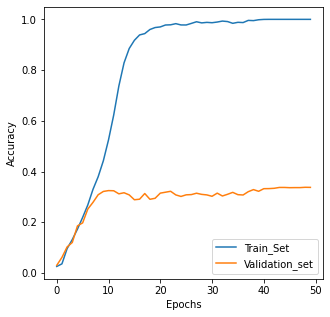

In [49]:
# Model1

# plot Accuracy vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model1 Accuracy vs Epochs plot.jpg')

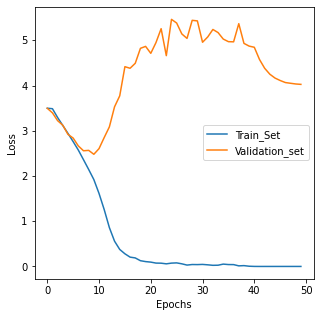

In [50]:
# plot Loss vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model1 Loss vs Epochs plot.jpg')

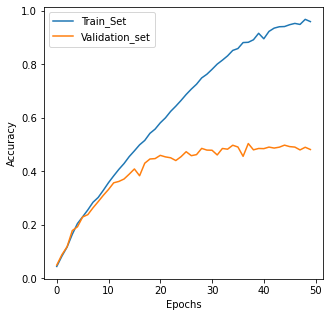

In [51]:
# Model1

# plot Accuracy vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model2 Accuracy vs Epochs plot.jpg')

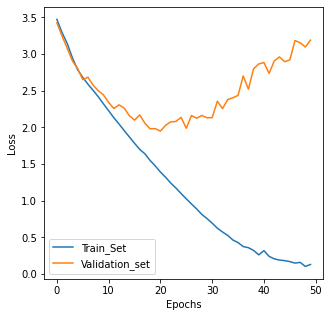

In [52]:
# plot Loss vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model2 Loss vs Epochs plot.jpg')

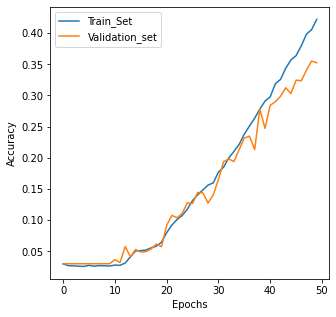

In [53]:
# Model3

# plot Accuracy vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model3 Accuracy vs Epochs plot.jpg')

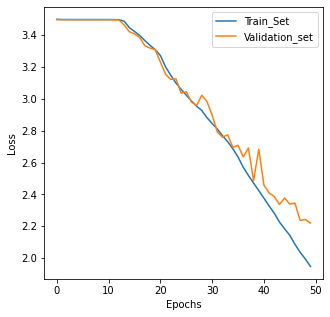

In [54]:
# plot Loss vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model3 Loss vs Epochs plot.jpg')

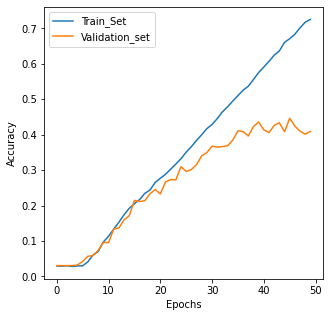

In [55]:
# Model4

# plot Accuracy vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model4 Accuracy vs Epochs plot.jpg')

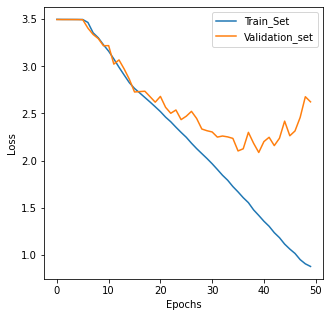

In [56]:
# plot Loss vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Set','Validation_set'])
fig.savefig('Model4 Loss vs Epochs plot.jpg')

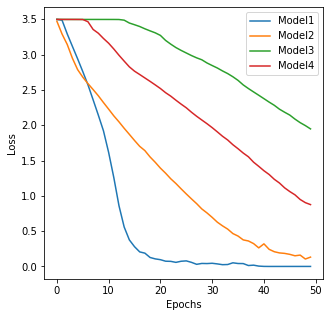

In [57]:
# Train Loss vs Epochs of all the above models
# plot Loss vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(train_loss1)
plt.plot(train_loss2)
plt.plot(train_loss3)
plt.plot(train_loss4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Model1','Model2', 'Model3', 'Model4'])
fig.savefig('All Models Loss vs Epochs plot.jpg')

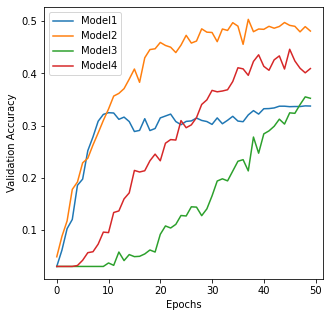

In [58]:
# Train Accuracy vs Epochs of all the above models
# plot Accuracy vs Epochs
fig=plt.figure(figsize=(5,5))
plt.plot(val_acc1)
plt.plot(val_acc2)
plt.plot(val_acc3)
plt.plot(val_acc4)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(['Model1','Model2', 'Model3', 'Model4'])
fig.savefig('All Models Validation Accuracy vs Epochs plot.jpg')

In [59]:
# part B

In [60]:
# 2.1

In [61]:
# to get probability of true label
def true_label_probab(img, label, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    yb = F.softmax(yb)
    # Pick index with true label probability
    preds  = yb[0][label]
    # Retrieve the class label
    return preds.item()

In [62]:
# occlusion sensitivity code

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
    print(width, height)
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    #print(height, output_height, width, output_width)
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            #print(h, w)
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            prob = true_label_probab(input_image, label, model)
            

            heatmap[h, w] = prob 

    return heatmap

In [63]:
# function to plot a given image
def show_image(image, label):
  print('label:', valset.classes[label], 'class: ',label)
  return plt.imshow(image.permute(1,2,0)) # to change the channels from 3,84,84 to 84,84,3

In [64]:
import seaborn as sns

In [69]:
# load a model
model = Net2()
model.load_state_dict(torch.load('model2.pth'))
model.eval()
to_device(model, device)

Net2(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: Ibizan_hound class:  0


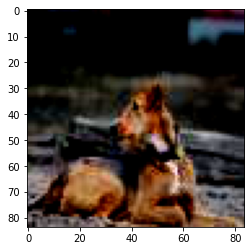

In [99]:
# Image 1
image, label = valset[10]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


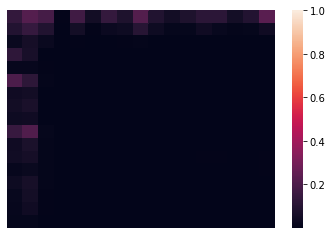

In [100]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 2, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: aircraft_carrier class:  1


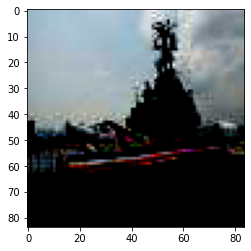

In [72]:
# Image 2
image, label = valset[100]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


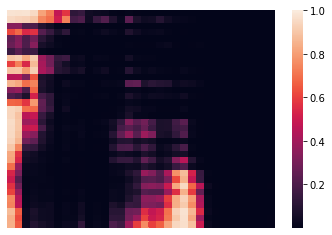

In [73]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: beer_bottle class:  2


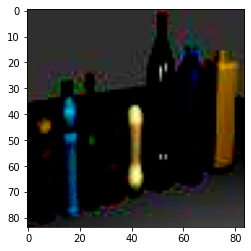

In [101]:
# Image 3
image, label = valset[201]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


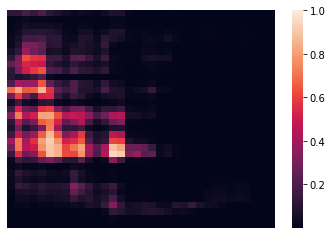

In [102]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: bolete class:  3


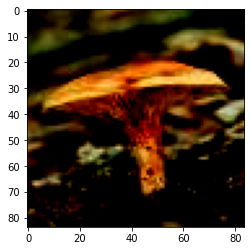

In [111]:
# Image 4
image, label = valset[340]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


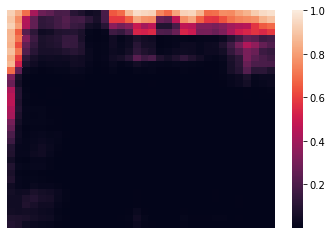

In [112]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: boxer class:  4


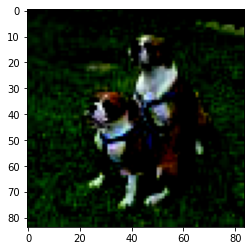

In [78]:
# Image 5
image, label = valset[400]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


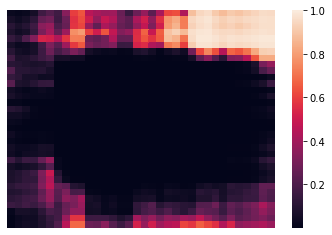

In [79]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: carton class:  5


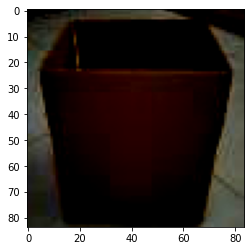

In [80]:
# Image 6
image, label = valset[500]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


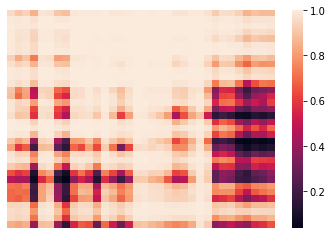

In [81]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: prayer_rug class:  20


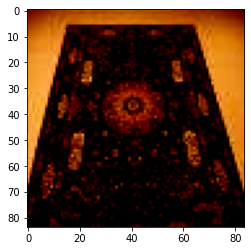

In [119]:
# Image 7
image, label = valset[2000]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


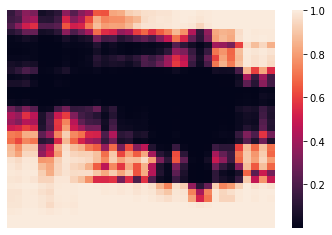

In [120]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: file class:  8


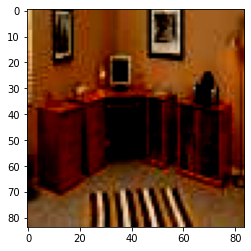

In [141]:
# Image 8
image, label = valset[850]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


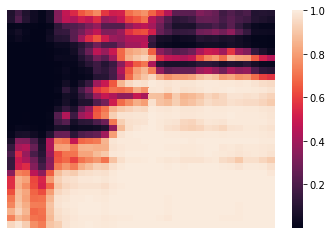

In [142]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: file class:  8


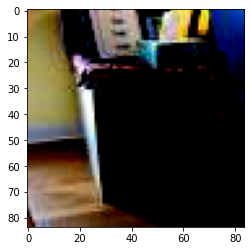

In [86]:
# Image 9
image, label = valset[800]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


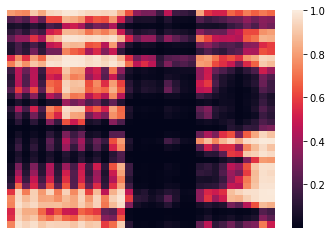

In [87]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: french_bulldog class:  9


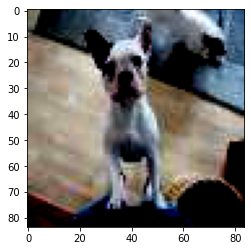

In [149]:
# Image 10
image, label = valset[970]
show_image(image,label)

84 84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


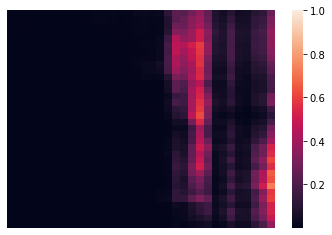

In [150]:
heatmap = occlusion(model, image, label, occ_size = 50, occ_stride = 1, occ_pixel = 0.5)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = 1)
figure = imgplot.get_figure()

In [151]:
# 2.2.1

In [157]:
from matplotlib import patches
def patch(image, i, j, layer):
  if (layer == 1):
    figure, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0))
    i=i
    j=j
    width = 2
    height = 2
    rect = patches.Rectangle((i,j),width,height,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  elif (layer == 2):
    figure, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0))
    i=i*2
    j=j*2
    width = 7
    height = 7
    rect = patches.Rectangle((i,j),width,height,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  elif (layer == 3):
    figure, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0))
    i=i*4
    j=j*4
    width = 17
    height = 17
    rect = patches.Rectangle((i,j),width,height,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  elif (layer == 4):
    figure, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0))
    i=i*4
    j=j*4
    width = 25
    height = 25
    rect = patches.Rectangle((i,j),width,height,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  elif (layer == 5):
    figure, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0))
    i=i*4
    j=j*4
    width = 33
    height = 33
    rect = patches.Rectangle((i,j),width,height,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [153]:
# load a model
model = Net4()
model.load_state_dict(torch.load('model4.pth'))
model.eval()

model_children = list(model.children())[0]
model_children

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (13): AvgPool2d(kernel_size=(4, 4), stride=1, padding=0)
  (14): Flatten()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): ReLU()
  (19): Linear(in_features=64, out_features=33, bias=True)
)

In [154]:
conv_layers = model_children[:14]
conv_layers

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (13): AvgPool2d(kernel_size=(4, 4), stride=1, padding=0)
)

In [155]:
%%time
max_val = [[] for i in range(10)]
max_index = [[] for i in range(10)]
for i in tqdm(range(len(testset))):

  image, label = testset[i]

  # unsqueeze to add a batch dimension
  input_image = image.unsqueeze(0)

  # get output from each layer
  result = []
  result.append(conv_layers[0](input_image))
  for layer in range(1, len(conv_layers)):
    result.append(conv_layers[layer](result[-1]))

  # conv layer at 0,3,6,8,10
  # let's choose output for kernel 3 and 12
  a = 3
  b = 12
  # kernel output selection in layer 1
  max_val[0].append(np.max(np.array((result[0][:, a,:,:].detach()))))
  max_index[0].append(np.unravel_index(torch.argmax((result[0].detach())[0][a]), (result[0].detach())[0][a].shape))

  max_val[1].append(np.max(np.array((result[0][:, b,:,:].detach()))))
  max_index[1].append(np.unravel_index(torch.argmax((result[0].detach())[0][b]), (result[0].detach())[0][b].shape))

  # kernel output selection in layer 2
  max_val[2].append(np.max(np.array((result[3][:, a,:,:].detach()))))
  max_index[2].append(np.unravel_index(torch.argmax((result[3].detach())[0][a]), (result[3].detach())[0][a].shape))

  max_val[3].append(np.max(np.array((result[3][:, b,:,:].detach()))))
  max_index[3].append(np.unravel_index(torch.argmax((result[3].detach())[0][b]), (result[3].detach())[0][b].shape))

  # kernel output selection in layer 3
  max_val[4].append(np.max(np.array((result[6][:, a,:,:].detach()))))
  max_index[4].append(np.unravel_index(torch.argmax((result[6].detach())[0][a]), (result[6].detach())[0][a].shape))

  max_val[5].append(np.max(np.array((result[6][:, b,:,:].detach()))))
  max_index[5].append(np.unravel_index(torch.argmax((result[6].detach())[0][b]), (result[6].detach())[0][b].shape))

  # kernel output selection in layer 4
  max_val[6].append(np.max(np.array((result[8][:, a,:,:].detach()))))
  max_index[6].append(np.unravel_index(torch.argmax((result[8].detach())[0][a]), (result[8].detach())[0][a].shape))

  max_val[7].append(np.max(np.array((result[8][:, b,:,:].detach()))))
  max_index[7].append(np.unravel_index(torch.argmax((result[8].detach())[0][b]), (result[8].detach())[0][b].shape))

  # kernel output selection in layer 5
  max_val[8].append(np.max(np.array((result[10][:, a,:,:].detach()))))
  max_index[8].append(np.unravel_index(torch.argmax((result[10].detach())[0][a]), (result[10].detach())[0][a].shape))

  max_val[9].append(np.max(np.array((result[10][:, b,:,:].detach()))))
  max_index[9].append(np.unravel_index(torch.argmax((result[10].detach())[0][b]), (result[10].detach())[0][b].shape))
  
  save_value = max_val
  save_index = max_index

  max_value = list(max_val)
  max_index = list(max_index)

100%|██████████| 3300/3300 [00:27<00:00, 121.85it/s]

CPU times: user 21.1 s, sys: 3.28 s, total: 24.4 s
Wall time: 27.1 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

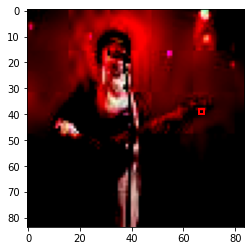

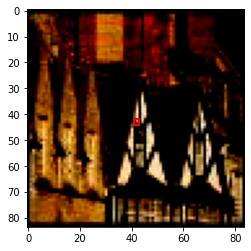

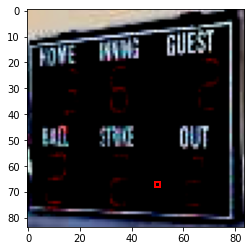

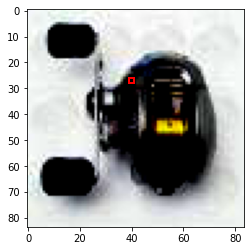

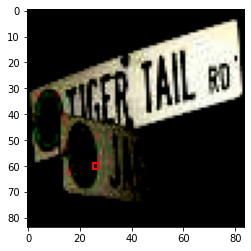

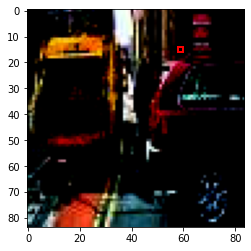

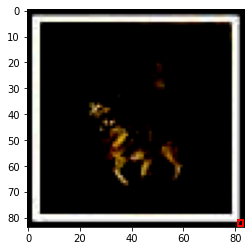

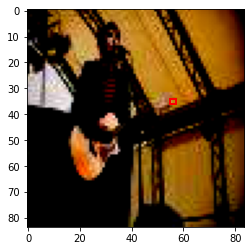

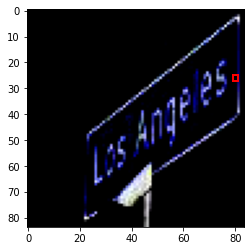

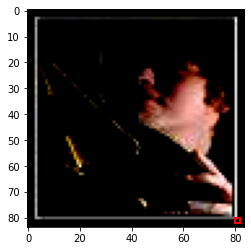

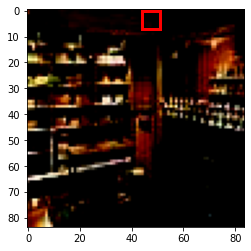

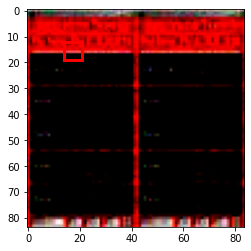

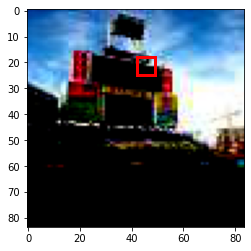

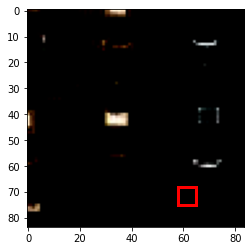

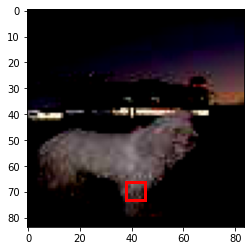

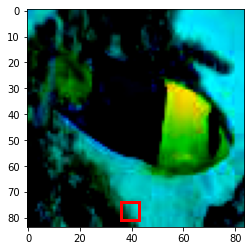

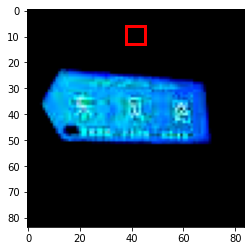

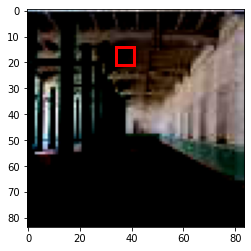

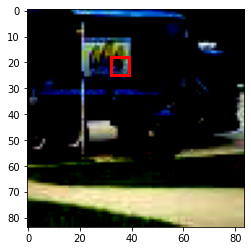

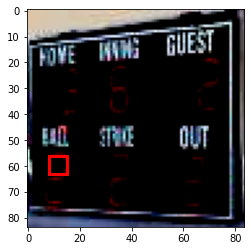

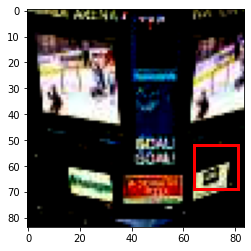

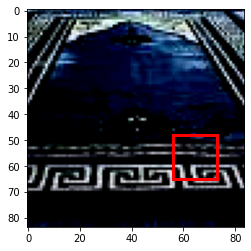

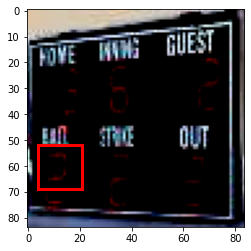

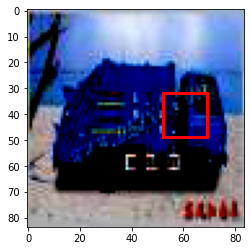

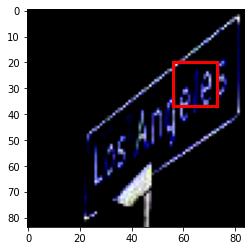

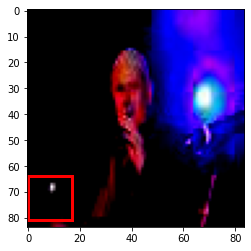

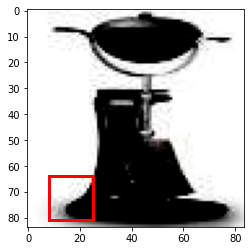

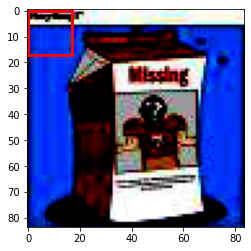

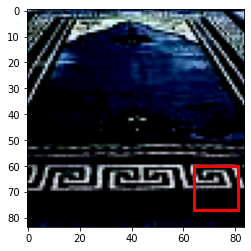

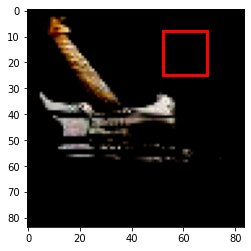

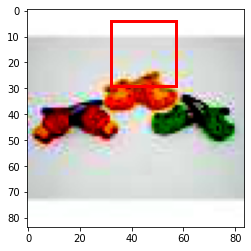

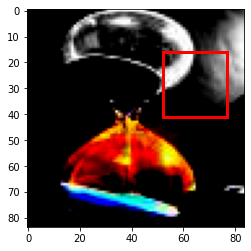

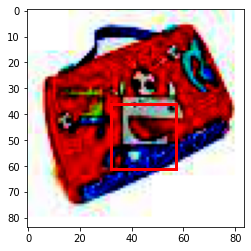

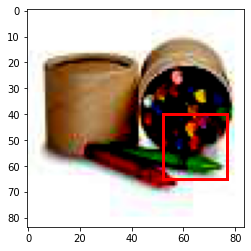

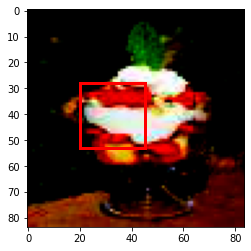

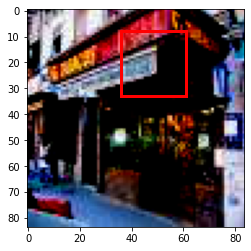

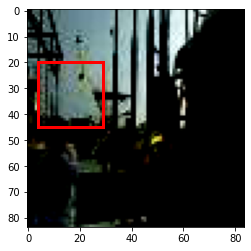

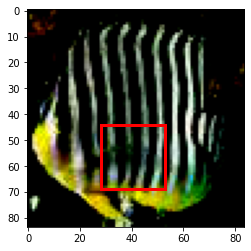

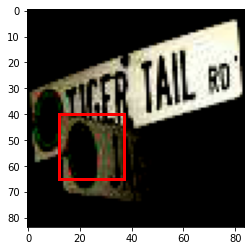

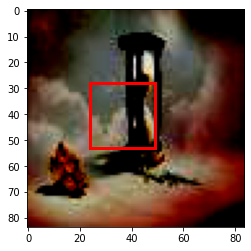

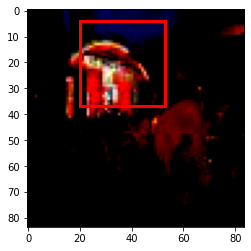

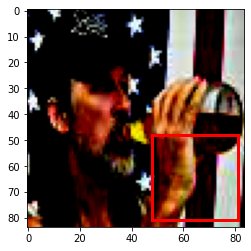

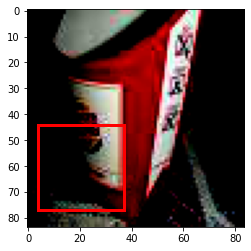

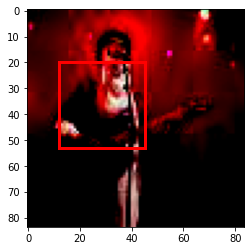

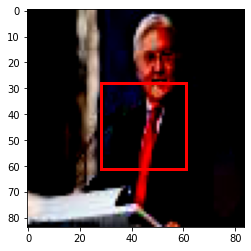

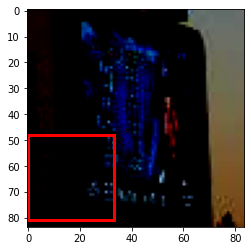

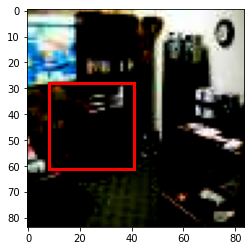

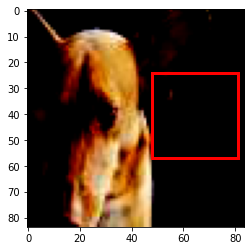

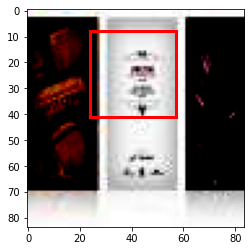

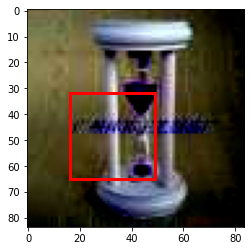

In [158]:
for i in range(10):
  top5 = np.array(max_val[i]).argsort()[-5:]
  for j in range(5):

    max_image = top5[j]
    top_index = max_index[i][max_image]

    max_value = list(max_value)
    
    image, label = testset[max_image]
    patch(image, top_index[0], top_index[1], (i//2)+1)

In [159]:
# 2.2.2

In [160]:
# load a model
model = Net4()
model.load_state_dict(torch.load('model4.pth'))
model.eval()

model_children = list(model.children())[0]
model_children

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (13): AvgPool2d(kernel_size=(4, 4), stride=1, padding=0)
  (14): Flatten()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): ReLU()
  (19): Linear(in_features=64, out_features=33, bias=True)
)

In [161]:
# Class wise accuracy before change
to_device(model, device)
classwise_test(val_loader, model)

100%|██████████| 825/825 [00:05<00:00, 153.56it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 41 %
Accuracy of aircraft_carrier : 54 %
Accuracy of beer_bottle : 41 %
Accuracy of     bolete : 32 %
Accuracy of      boxer : 22 %
Accuracy of     carton : 52 %
Accuracy of       dome : 25 %
Accuracy of electric_guitar :  2 %
Accuracy of       file : 44 %
Accuracy of french_bulldog : 10 %
Accuracy of garbage_truck : 45 %
Accuracy of golden_retriever : 32 %
Accuracy of gordon_setter : 45 %
Accuracy of hair_slide : 16 %
Accuracy of  hourglass : 37 %
Accuracy of house_finch : 49 %
Accuracy of   komondor : 63 %
Accuracy of   malamute : 30 %
Accuracy of    meerkat : 45 %
Accuracy of pencil_box : 43 %
Accuracy of prayer_rug : 53 %
Accuracy of       reel :  9 %
Accuracy of rock_beauty : 71 %
Accuracy of scoreboard : 57 %
Accuracy of solar_dish : 40 %
Accuracy of      stage : 43 %
Accuracy of street_sign : 41 %
Accuracy of       tank : 46 %
Accuracy of  tile_roof : 40 %
Accuracy of tobacco_shop : 42 %
Accuracy of     trifle : 67 %
Accuracy of wh

In [162]:
# class wise accuracy after change
model_children[0].weight[3] = torch.zeros(size=model_children[0].weight[3].shape)
model_children[0].weight[12] = torch.zeros(size=model_children[0].weight[12].shape)

model_children[3].weight[3] = torch.zeros(size=model_children[3].weight[3].shape)
model_children[3].weight[12] = torch.zeros(size=model_children[3].weight[12].shape)

model_children[6].weight[3] = torch.zeros(size=model_children[6].weight[3].shape)
model_children[6].weight[12] = torch.zeros(size=model_children[6].weight[12].shape)

model_children[8].weight[3] = torch.zeros(size=model_children[8].weight[3].shape)
model_children[8].weight[12] = torch.zeros(size=model_children[8].weight[12].shape)

model_children[10].weight[3] = torch.zeros(size=model_children[10].weight[3].shape)
model_children[10].weight[12] = torch.zeros(size=model_children[10].weight[12].shape)

to_device(model, device)
classwise_test(val_loader, model)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:385: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if param.grad is not None:
100%|██████████| 825/825 [00:05<00:00, 152.16it/s]


class-wise accuracy
Accuracy of Ibizan_hound : 40 %
Accuracy of aircraft_carrier : 50 %
Accuracy of beer_bottle : 20 %
Accuracy of     bolete : 29 %
Accuracy of      boxer : 18 %
Accuracy of     carton : 53 %
Accuracy of       dome : 27 %
Accuracy of electric_guitar :  1 %
Accuracy of       file : 24 %
Accuracy of french_bulldog :  1 %
Accuracy of garbage_truck :  7 %
Accuracy of golden_retriever : 44 %
Accuracy of gordon_setter : 29 %
Accuracy of hair_slide : 13 %
Accuracy of  hourglass : 18 %
Accuracy of house_finch : 56 %
Accuracy of   komondor : 57 %
Accuracy of   malamute : 21 %
Accuracy of    meerkat : 55 %
Accuracy of pencil_box : 54 %
Accuracy of prayer_rug : 66 %
Accuracy of       reel :  5 %
Accuracy of rock_beauty : 69 %
Accuracy of scoreboard : 13 %
Accuracy of solar_dish : 24 %
Accuracy of      stage : 24 %
Accuracy of street_sign : 20 %
Accuracy of       tank : 31 %
Accuracy of  tile_roof : 40 %
Accuracy of tobacco_shop : 27 %
Accuracy of     trifle : 54 %
Accuracy of wh